In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
import os
import re
import glob
import pandas as pd
from sklearn.metrics import mean_squared_error

In [3]:
# Load CNN and UNET
from CNN_Mask_to_Tens import CNN
from UNet import UNet

In [4]:
# Create a new folder to store the output figures
output_folder = "output_figures_Unet"
os.makedirs(output_folder, exist_ok=True)

# Define the input folder containing the images
input_folder = "R3080_realval"

model = UNet()
# Load the trained weights
model.load_state_dict(torch.load('Unet_R3080.pt'))
model.eval()

# Load and preprocess each input image
image_files = glob.glob(os.path.join(input_folder, "*.png"))  # Change the file extension if necessary

for image_file in image_files:
    # Load and preprocess the input image
    image = Image.open(image_file)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4414, 0.4456, 0.3421], std=[0.2741, 0.2734, 0.3030])
    ])
    image = image.convert('RGB')
    image = transform(image)  

    # Make a prediction
    with torch.no_grad():
        output = model(image.unsqueeze(0))

    # Convert the output tensor to a numpy array
    output_np = output.squeeze(0).squeeze(0).cpu().detach().numpy()

    # Apply a threshold to convert the output to a binary mask
    threshold = 0.5  # Adjust the threshold value as needed
    mask = (output_np >= threshold).astype(np.uint8)

    # Convert the binary mask to a PIL Image
    pil_image = transforms.ToPILImage()(mask)

    # Convert the PIL Image to a NumPy array
    numpy_image = np.array(pil_image)

    # Save the output image
    output_filename = os.path.splitext(os.path.basename(image_file))[0] + "_output.jpg"
    output_path = os.path.join(output_folder, output_filename)
    
    # Save the image using plt.savefig()
    plt.imsave(output_path, numpy_image)

In [5]:

image = Image.open('output_figures_Unet\drop_s30_v5_r0.5_str4_pos2_cam4_output.jpg')  # Replace 'input_image.jpg' with the path to your input image file

transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.4753, 0.4753, 0.4753])
])

transformed_image = transform(image)

# Binarize inputs
threshold = 0.5
inputs = torch.where(transformed_image >= threshold, torch.ones_like(transformed_image), torch.zeros_like(transformed_image))

inputs = inputs.unsqueeze(0)[:,:1,:,:] # Select 1 channel

# Create an instance of your CNN model
model = CNN()

# Load the pre-trained weights
model.load_state_dict(torch.load('trained_model_Train_10200_simple.pt'))
model.eval()

#Make a prediction
with torch.no_grad():
    output_CNN = model(inputs)

# Convert the output to a readable format
predicted_value = output_CNN.item()

# Print the predicted value
print('Predicted value:', predicted_value)


Predicted value: 32.033836364746094


In [6]:
# Create an instance of your CNN model
model = CNN()

# Load the pre-trained weights
model.load_state_dict(torch.load('trained_model_Train_10200_simple.pt'))
model.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.4753, 0.4753, 0.4753])
])

# Specify the folder containing PNG files
folder_path = 'output_figures_Unet'

# Create a list to store the extracted values and predictions
data = []

# Loop over each PNG file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        # Extract the real value from the filename
        real_value = float(filename.split("_s")[1].split("_")[0])

        # Load and preprocess the input image
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        transformed_image = transform(image)

        # Binarize inputs
        threshold = 0.5
        inputs = torch.where(transformed_image >= threshold, torch.ones_like(transformed_image), torch.zeros_like(transformed_image))

        inputs = inputs.unsqueeze(0)[:,:1,:,:]  # Select 1 channel

        # Make a prediction
        with torch.no_grad():
            output_CNN = model(inputs)

        # Convert the output to a readable format
        predicted_value = output_CNN.item()

        # Append the real value and predicted value to the data list
        data.append((real_value, predicted_value))

# Create a dataframe from the data list
df = pd.DataFrame(data, columns=["Real Value", "Predicted Value"])

# Calculate the difference between real_value and predicted_value
df['Difference'] = df['Real Value'] - df['Predicted Value']

# Print the modified DataFrame
print(df)

    Real Value  Predicted Value  Difference
0         30.0        30.693792   -0.693792
1         30.0        29.597069    0.402931
2         30.0        29.851631    0.148369
3         30.0        31.045670   -1.045670
4         30.0        32.190872   -2.190872
5         30.0        31.160711   -1.160711
6         30.0        29.600239    0.399761
7         30.0        29.586588    0.413412
8         30.0        30.004063   -0.004063
9         30.0        28.878178    1.121822
10        30.0        30.624796   -0.624796
11        30.0        29.557686    0.442314
12        30.0        29.833735    0.166265
13        30.0        31.042912   -1.042912
14        30.0        32.213589   -2.213589
15        30.0        31.161579   -1.161579
16        30.0        29.597630    0.402370
17        30.0        29.582081    0.417919
18        30.0        29.970592    0.029408
19        30.0        28.844240    1.155760
20        30.0        30.603840   -0.603840
21        30.0        29.553345 

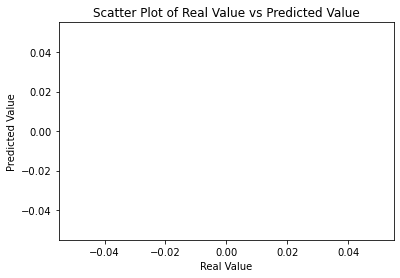

In [7]:
# Filter the predictions_test_df to include only the range 40-70 real values $$$
filtered_predictions_test_df = df[(df['Real Value'] >= 40) & (df['Real Value'] <= 70)]

# Create a scatter plot
plt.scatter(filtered_predictions_test_df['Real Value'], filtered_predictions_test_df['Predicted Value'], marker='x')

# Plot the line y = x
x = np.linspace(filtered_predictions_test_df['Real Value'].min(), filtered_predictions_test_df['Real Value'].max(), 100)
plt.plot(x, x, color='orange')

# Set plot labels and title
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title('Scatter Plot of Real Value vs Predicted Value')

# Save plot
plt.savefig('Scatter_real_vs_pred_total.jpeg', format='jpeg')

# Display the plot
plt.show()

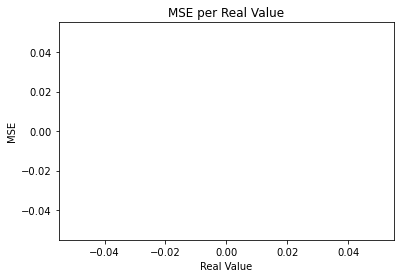

In [8]:
# Calculate the MSE per real value
mse_per_real_value_test = filtered_predictions_test_df.groupby('Real Value')['Difference'].apply(lambda x: mean_squared_error(x, np.zeros_like(x)))

# Plot the MSE per real value
plt.bar(mse_per_real_value_test.index, mse_per_real_value_test)
plt.xlabel('Real Value')
plt.ylabel('MSE')
plt.title('MSE per Real Value')

# Save plot
plt.savefig('MSE_per_real_total.jpeg', format='jpeg')

# Show the plot
plt.show()

In [9]:
# Define hit
max_dif = 0.5

# Calculate the accuracy
hits = df[abs(df['Real Value'] - df['Predicted Value']) <= max_dif]
accuracy = len(hits) / len(df) * 100

# Calculate the MSE
mse = mean_squared_error(df['Real Value'], df['Predicted Value'])

# Print the MSE
print("Average MSE: {:.2f}".format(mse))
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy))

Average MSE: 0.94
Accuracy: 50.00%
